In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import cmocean
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
coastline = cfeature.GSHHSFeature(scale='full',levels=[1]) 
import xarray as xr
import geopandas as gpd


In [9]:
# Load data
site1_1030 = pd.read_excel('Bioscape_SHB_CTD.xlsx', 'site1_1030')
site2_1030 = pd.read_excel('Bioscape_SHB_CTD.xlsx', 'site2_1030')
site3_1030 = pd.read_excel('Bioscape_SHB_CTD.xlsx', 'site3_1030')
site4_1030 = pd.read_excel('Bioscape_SHB_CTD.xlsx', 'site4_1030')
site5_1030 = pd.read_excel('Bioscape_SHB_CTD.xlsx', 'site5_1030')

site1_1108 = pd.read_excel('Bioscape_WB_CTD.xlsx', 'site1_1108')
site2_1108 = pd.read_excel('Bioscape_WB_CTD.xlsx', 'site2_1108')
site3_1108 = pd.read_excel('Bioscape_WB_CTD.xlsx', 'site3_1108')
site4_1108 = pd.read_excel('Bioscape_WB_CTD.xlsx', 'site4_1108')

site1_1026 = pd.read_excel('Bioscape_AB_CTD.xlsx', 'site1_1026')
site2_1026 = pd.read_excel('Bioscape_AB_CTD.xlsx', 'site2_1026')
site3_1026 = pd.read_excel('Bioscape_AB_CTD.xlsx', 'site3_1026')
site4_1026 = pd.read_excel('Bioscape_AB_CTD.xlsx', 'site4_1026')
site5_1026 = pd.read_excel('Bioscape_AB_CTD.xlsx', 'site5_1026')
site6_1026 = pd.read_excel('Bioscape_AB_CTD.xlsx', 'site6_1026')
site7_1026 = pd.read_excel('Bioscape_AB_CTD.xlsx', 'site7_1026')
site8_1026 = pd.read_excel('Bioscape_AB_CTD.xlsx', 'site8_1026')
site9_1026 = pd.read_excel('Bioscape_AB_CTD.xlsx', 'site9_1026')

In [ ]:
# Define a function to smooth and filter data
def smooth_and_filter(data, window_size=1, threshold=1):
    """
    Smooth data using a rolling mean and filter outliers using a threshold.
    """
    # Smooth data using rolling mean
    smoothed = data.rolling(window=window_size, center=True, min_periods=1).mean()
    
    # Filter outliers based on deviation from smoothed data
    filtered = data.copy()
    filtered[abs(data - smoothed) > threshold] = np.nan
    
    return filtered

# Define a function to ensure depth is monotonically increasing (for downcasts)
def ensure_monotonic_increasing(depth, salinity, temperature):
    """
    Ensure depth values are monotonically increasing and adjust salinity/temperature accordingly.
    """
    # Create a mask for monotonically increasing depth
    mask = np.diff(depth) < 0
    mask = np.insert(mask, 0, True)  # Keep the first value
    
    # Apply the mask to depth, salinity, and temperature
    depth_filtered = depth[mask]
    salinity_filtered = salinity[mask]
    temperature_filtered = temperature[mask]
    
    return depth_filtered, salinity_filtered, temperature_filtered

# Process site data with smoothing, filtering, and monotonic depth adjustment
def process_site_data(site_data, depth_indices):
    """
    Process depth, salinity, and temperature data for a site.
    """
    depth = site_data.depth[depth_indices[0]:depth_indices[1]]
    salinity = site_data.salinity[depth_indices[0]:depth_indices[1]]
    temperature = site_data.temperature[depth_indices[0]:depth_indices[1]]
    
    # # Smooth and filter depth, salinity, and temperature
    # depth_filtered = smooth_and_filter(depth)
    # salinity_filtered = smooth_and_filter(salinity)
    # temperature_filtered = smooth_and_filter(temperature)
    
    # Ensure depth is monotonically increasing
    depth_monotonic, salinity_monotonic, temperature_monotonic = ensure_monotonic_increasing(
        depth, salinity, temperature
    )
    
    return depth, salinity, temperature

# Define a function for non-linear depth scaling (1/3 for first 5m)
def depth_transform(depth):
    """
    Transform depth values so that:
    - First 5m takes up 1/3 of the vertical space
    - Remaining depths (5m to max) are compressed into the bottom 2/3
    """
    max_depth = 50  # Adjust based on your maximum depth
    if depth <= 5:  # Changed from 10 to 5
        # First 5m: linear mapping to 0-1/3
        return depth / 15  # 5/15 = 1/3
    else:
        # Remaining depths: compressed into 1/3-1.0
        return (1/3) + (depth - 5) / (1.5 * (max_depth - 5))  # Changed from 10 to 5

def inverse_depth_transform(transformed_depth):
    """
    Inverse transform for tick positioning
    """
    max_depth = 50
    if transformed_depth <= 1/3:
        # First third corresponds to 0-5m
        return transformed_depth * 15  # Changed from 30 to 15
    else:
        # Remaining two-thirds corresponds to 5m-max_depth
        return 5 + (transformed_depth - 1/3) * (1.5 * (max_depth - 5))  

def transform_depth_grid(depth_grid, value_grid, max_depth=50):
    """
    Transform the entire depth grid for contour plotting
    """
    # Create transformed depth axis (0 to 1)
    transformed_depth_axis = np.linspace(0, 1, 100)
    
    # Transform the original depth values
    transformed_value_grid = np.full((len(transformed_depth_axis), value_grid.shape[1]), np.nan)
    
    for i, depth_val in enumerate(transformed_depth_axis):
        original_depth = inverse_depth_transform(depth_val)
        if original_depth <= depth_grid[-1, 0]:  # Within data range
            # Find closest depth in original grid
            depth_idx = np.argmin(np.abs(depth_grid[:, 0] - original_depth))
            transformed_value_grid[i, :] = value_grid[depth_idx, :]
    
    return transformed_depth_axis, transformed_value_grid

In [11]:
# Cleaned data

# Process SHB sites
shb_st1_d, shb_st1_s, shb_st1_t = process_site_data(site1_1030, [0,169])
shb_st2_d, shb_st2_s, shb_st2_t = process_site_data(site2_1030, [0,269])
shb_st3_d, shb_st3_s, shb_st3_t = process_site_data(site3_1030, [0, 258])
shb_st4_d, shb_st4_s, shb_st4_t = process_site_data(site4_1030, [0, 345])
shb_st5_d, shb_st5_s, shb_st5_t = process_site_data(site5_1030, [0,463])

# Process WB sites
wb_wb1_d, wb_wb1_s, wb_wb1_t = process_site_data(site1_1108, [940, 1560])
wb_wb2_d, wb_wb2_s, wb_wb2_t = process_site_data(site2_1108, [905, 1450])
wb_wb3_d, wb_wb3_s, wb_wb3_t = process_site_data(site3_1108, [974, 1505])
wb_wb4_d, wb_wb4_s, wb_wb4_t = process_site_data(site4_1108, [951, 1465])

# Process AB sites
ab_ab1_d, ab_ab1_s, ab_ab1_t = process_site_data(site1_1026, [358, 579])
ab_ab2_d, ab_ab2_s, ab_ab2_t = process_site_data(site2_1026, [434, 630])
ab_ab3_d, ab_ab3_s, ab_ab3_t = process_site_data(site3_1026, [620, 875])
ab_ab4_d, ab_ab4_s, ab_ab4_t = process_site_data(site4_1026, [425, 653])
ab_ab5_d, ab_ab5_s, ab_ab5_t = process_site_data(site5_1026, [455, 655])

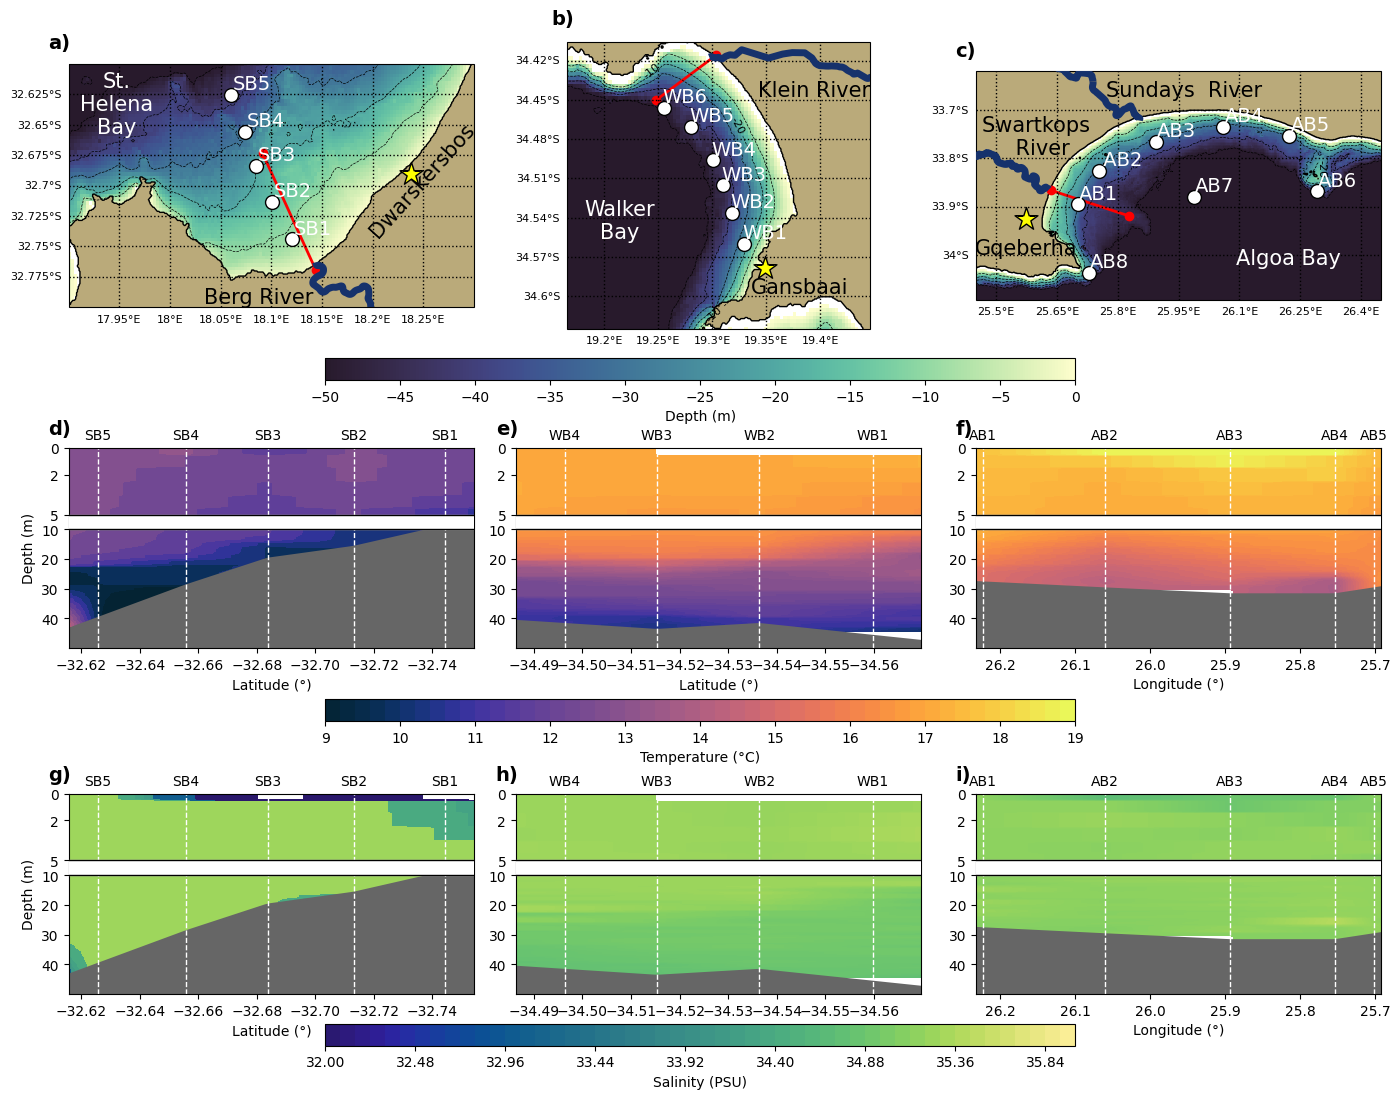

In [ ]:
#PLOTTING BEGINS--------------------------------------------------------------------------------------------------------
# Load the .grd file
filename = "/Users/opticslab/Documents/BIOSCAPE/bathymetry/Willem de Wet Bathymetry of Southern Africa Continental Shelf.grd"

klein_river = gpd.read_file('/Users/opticslab/Documents/BIOSCAPE/rivers/klein_river.geojson')
klein_river["geometry"] =klein_river["geometry"].translate(xoff=0.005)
berg_river = gpd.read_file('/Users/opticslab/Documents/BIOSCAPE/rivers/berg_river.geojson')
berg_river["geometry"] =berg_river["geometry"].translate(yoff=0.005)

swartkops_river = gpd.read_file('/Users/opticslab/Documents/BIOSCAPE/rivers/swartkops_river.geojson')
sundays_river = gpd.read_file('/Users/opticslab/Documents/BIOSCAPE/rivers/sundays_river.geojson')


data = xr.open_dataset(filename, engine = 'rasterio')

depth = data.band_data[0,:,:]


# Figure and GridSpec layout
fig = plt.figure(figsize=(15, 11), layout="compressed")
    
gs = fig.add_gridspec(3, 3, height_ratios=[1, 0.7, 0.7], width_ratios = [1,1,1],hspace = 0.2)

import pickle
with open('berg_river.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
    bergriv_lon, bergriv_lat, bergriv_val = pickle.load(f)



coordinate_bounds = [
    {
        'lat_min': -32.8, 'lat_max': -32.6, 'lon_min': 17.9, 'lon_max': 18.3,
        'station_lats': [-32.7444, -32.7132, -32.6837, -32.6558, -32.6256],
        'station_lons': [18.1202, 18.1002, 18.0850, 18.0740, 18.0602],
        'station_labels': ['SB1', 'SB2', 'SB3', 'SB4', 'SB5'],
        'river_lat': bergriv_lat,
        'river_lon': bergriv_lon,
        'river_val': bergriv_val,
        'transect': [18.143835, 18.091395, -32.769543, -32.673543]
    },
    {
        'lat_min': -34.624719, 'lat_max': -34.406115, 'lon_min': 19.165716, 'lon_max': 19.446512,
        'station_lats': [-34.5598025, -34.53643167,-34.51526167, -34.496295, -34.4704083, -34.4559425], 
        'station_lons': [19.32974,19.318015, 19.310449167, 19.3006783, 19.28072167, 19.2557475],  
        'station_labels': ['WB1', 'WB2', 'WB3', 'WB4', 'WB5','WB6'], 
        'transect': [19.303352, 19.248422, -34.416048, -34.450023
]
    },
    {
        'lat_min': -33.62, 'lat_max': -34.092873, 'lon_min': 25.45, 'lon_max': 26.45,
        'station_lats': [-33.8958, -33.82585,-33.766318, -33.73517,-33.754123,-33.868695, -33.880513, -34.03797],  # No stations in this region
        'station_lons': [25.7019, 25.753738, 25.89355, 26.060795, 26.222993,26.29019167, 25.9876683, 25.729173],  # No stations in this region
        'station_labels': ['AB1',' AB2','AB3','AB4','AB5','AB6','AB7','AB8'],  # No stations in this region
        'transect': [ 25.634920, 25.827816, -33.866301, -33.919427]
    }
]



# Loop through each set of bounds
for i, bounds in enumerate(coordinate_bounds):
    # Extract the bounding box
    lat_min = bounds['lat_min']
    lat_max = bounds['lat_max']
    lon_min = bounds['lon_min']
    lon_max = bounds['lon_max']

    ax_d = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree(), aspect="auto")
    ax_d.set_extent([lon_max,lon_min, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax_d.add_feature(coastline, ec=(0,0,0,1),fc='#BAAA7A', alpha = 1)

    gl = ax_d.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                linewidth=1, color='k', linestyle=':')
        
    gl.top_labels=False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    cs1=ax_d.pcolormesh(data.x, data.y, data.band_data[0,:,:], cmap = cmocean.cm.deep_r,vmin = -50, vmax =0)
    
    # Plot transect lines
    ax_d.plot([bounds['transect'][0], bounds['transect'][1]], [bounds['transect'][2], bounds['transect'][3]], 
        color='red', linewidth=2, marker='o')

    # Add contour lines
    contour_levels = np.arange(-50, 0, 10)  # Define contour levels (e.g., from 0 to 50 in steps of 5)
    contour_plot = ax_d.contour(data.x, data.y, data.band_data[0,:,:], levels=contour_levels, colors='black', linewidths=0.5)

    ax_d.clabel(contour_plot, inline=True, fontsize=8, fmt='%1.0f')
    ax_d.set_aspect('equal')  
    
    
    
    
    
    ax_d.scatter(bounds['station_lons'],bounds['station_lats'],100,marker = 'o',color = 'w', edgecolor = 'black', zorder= 8)
    for label, x, y in zip(bounds['station_labels'], bounds['station_lons'],bounds['station_lats']):
        ax_d.annotate(label, (x, y), textcoords="offset points", xytext=(15,4), ha='center',color = 'white',fontsize = 14, zorder = 8)
    if i == 0:
        berg_river.plot(ax=ax_d, color="#16326C", linewidth=5, label="River", zorder = 5)
        ax_d.scatter(18.237731,-32.690843,  s=300, marker = '*', cmap='turbo',edgecolors = 'black', color = 'yellow',zorder=8)
        ax_d.annotate('Dwarskersbos', (18.238,-32.71), rotation = 48, textcoords="offset points", xytext=(8,-28), ha='center',color = 'black', fontsize = 15)
        ax_d.annotate('Berg River', (18.06,-32.78), textcoords="offset points", xytext=(20,-15), ha='center',color = 'black', fontsize = 15)
        ax_d.annotate('St.\nHelena\nBay', (17.92,-32.64), textcoords="offset points", xytext=(20,-15), ha='center',color = 'white', fontsize = 15)
    elif i == 1:
        klein_river.plot(ax=ax_d, color="#16326C", linewidth=5, label="River", zorder = 5)
        ax_d.scatter(19.349022,-34.578253,  s=300, marker = '*', cmap='turbo',edgecolors = 'black', color = 'yellow',zorder=8)
        ax_d.annotate('Gansbaai', (19.349022,-34.578253), textcoords="offset points", xytext=(25,-18), ha='center',color = 'black', fontsize = 15)
        ax_d.annotate('Klein River', (19.330112,-34.431399), textcoords="offset points", xytext=(50,-15),ha='center',color = 'black', fontsize = 15)
        ax_d.annotate('Walker\nBay', (19.15,-34.54), textcoords="offset points", xytext=(50,-15),ha='center',color = 'white', fontsize = 15)

    elif i ==2:
        swartkops_river.plot(ax=ax_d, color="#16326C", linewidth=5, label="River", zorder = 5)
        sundays_river.plot(ax=ax_d, color="#16326C", linewidth=5, label="River", zorder = 5)
        ax_d.scatter(25.573329, -33.926631,  s=300, marker = '*', cmap='turbo',edgecolors = 'black', color = 'yellow',zorder=8)
        ax_d.annotate('Gqeberha', (25.573329, -33.926631), textcoords="offset points", xytext=(0,-25), ha='center',color = 'black', fontsize = 15)
        ax_d.annotate('Swartkops \n River', (25.487583, -33.777749), textcoords="offset points", xytext=(35,-5),ha='center',color = 'black', fontsize = 15)
        ax_d.annotate('Sundays  River', (25.843067, -33.671548), textcoords="offset points", xytext=(35,0),ha='center',color = 'black', fontsize = 15)
        ax_d.annotate('Algoa Bay', (26.1, -34.02), textcoords="offset points", xytext=(35,0),ha='center',color = 'white', fontsize = 15)


vmin_d, vmax_d = -50, 0

cbar_ax_d = fig.add_axes([0.25, 0.63, 0.5, 0.02])  # depth
cbar_d = fig.colorbar(cs1, cax=cbar_ax_d, orientation="horizontal")
cbar_d.set_label("Depth (m)")
cbar_d.set_ticks(np.linspace(vmin_d, vmax_d, num=11))  # Ensure proper tick spacing


vmin_t, vmax_t = 9, 19  # Temperature range (adjust based on actual data)
vmin_s, vmax_s = 32, 36  # Salinity range

# Define colormaps
cmap_temp = cmocean.cm.thermal
cmap_sal = cmocean.cm.haline

# Define locations (same structure)
locations = {
    "Location 1": {
        "latitudes": [-32.7444, -32.7132, -32.6837, -32.6558, -32.6256],
        "depths": [shb_st1_d, shb_st2_d, shb_st3_d, shb_st4_d, shb_st5_d],
        "bottom_depths": [9, 16, 20, 29, 40],
        "s_values": [shb_st1_s, shb_st2_s, shb_st3_s, shb_st4_s, shb_st5_s],
        "t_values": [shb_st1_t, shb_st2_t, shb_st3_t, shb_st4_t, shb_st5_t],
        "station": ['SB1', 'SB2', 'SB3', 'SB4', 'SB5'],
        "ylim": [40, -5]
    },
    "Location 2": {
        "latitudes": [-34.5598, -34.5364, -34.5153, -34.4963],
        "depths": [wb_wb1_d, wb_wb2_d, wb_wb3_d, wb_wb4_d],
        "bottom_depths": [46, 42, 44, 42],
        "s_values": [wb_wb1_s, wb_wb2_s, wb_wb3_s, wb_wb4_s],
        "t_values": [wb_wb1_t, wb_wb2_t, wb_wb3_t, wb_wb4_t],
        "station": ['WB1', 'WB2', 'WB3', 'WB4'],
        "ylim": [50, -6]
    },
    "Location 3": {
        "longitudes": [25.7019, 25.7537, 25.8935, 26.0608, 26.2229],
        "depths": [ab_ab1_d, ab_ab2_d, ab_ab3_d, ab_ab4_d, ab_ab5_d],
        "bottom_depths": [28, 30, 32, 32, 30],
        "s_values": [ab_ab1_s, ab_ab2_s, ab_ab3_s, ab_ab4_s, ab_ab5_s],
        "t_values": [ab_ab1_t, ab_ab2_t, ab_ab3_t, ab_ab4_t, ab_ab5_t],
        "station": ['AB1', 'AB2', 'AB3', 'AB4', 'AB5'],
        "ylim": [35, -5]
    }
}

all_cs_temp = []
all_cs_sal = []
res = 100
# Create subplots
temp_axes = [fig.add_subplot(gs[1, i], aspect="auto") for i in range(3)]
sal_axes = [fig.add_subplot(gs[2, i], aspect="auto") for i in range(3)]

for i, ((ax_t, ax_s), (location, data)) in enumerate(zip(zip(temp_axes, sal_axes), locations.items())):
    coord_label = "Latitude (°)" if "latitudes" in data else "Longitude (°)"
    coords = data.get("latitudes", data.get("longitudes"))

    if i == 2:
        coords = coords[::-1]  # Reverse third panel


    # Create fine coordinate and depth grids (in original depth space)
    fine_coord_grid = np.linspace(min(coords) - 0.01, max(coords) + 0.01, res)
    depth_grid = np.arange(0, 46, 1)
    fine_coord_mesh, depth_mesh = np.meshgrid(fine_coord_grid, depth_grid)

    bottom_interp = interp1d(coords, data["bottom_depths"], kind='linear', fill_value="extrapolate")
    bottom_depths = bottom_interp(fine_coord_grid)

    def interpolate_values(values):
        grid = np.full_like(fine_coord_mesh, np.nan, dtype=float)
        for depth_idx, depth in enumerate(depth_grid):
            depth_vals = []
            for j, (depth_list, value_list, bottom_depth) in enumerate(zip(data["depths"], values, data["bottom_depths"])):
                depth_list = np.array(depth_list)
                value_list = np.array(value_list)
                
                if depth <= 45:
                    if depth in depth_list:
                        depth_idx_in_list = np.where(depth_list == depth)[0]
                        if len(depth_idx_in_list) > 0:
                            depth_vals.append(value_list[depth_idx_in_list[0]])
                    else:
                        interp_func = interp1d(depth_list, value_list, kind='linear', fill_value="extrapolate")
                        depth_vals.append(interp_func(depth))
                else:
                    depth_vals.append(np.nan)

            interp_func_coord = interp1d(coords, depth_vals, kind='linear', fill_value="extrapolate")
            grid[depth_idx, :] = interp_func_coord(fine_coord_grid)
        return grid

    temp_grid = interpolate_values(data["t_values"])
    sal_grid = interpolate_values(data["s_values"])
    
    # Transform depth grids for non-linear scaling
    transformed_depth_axis, transformed_temp_grid = transform_depth_grid(depth_mesh, temp_grid)
    transformed_depth_axis, transformed_sal_grid = transform_depth_grid(depth_mesh, sal_grid)
    
    # Create meshgrid for transformed space
    transformed_coord_mesh, transformed_depth_mesh = np.meshgrid(fine_coord_grid, transformed_depth_axis)
    
    # Transform bottom depths
    transformed_bottom_depths = np.array([depth_transform(d) for d in bottom_depths])

    # Contour plots in transformed space
    cs_temp = ax_t.contourf(transformed_coord_mesh, transformed_depth_mesh, transformed_temp_grid, 
                           levels=50, vmin=vmin_t, vmax=vmax_t, cmap=cmap_temp)
    
    if i == 0:
        custom_levels = np.array([19,19.5,20,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25,25.5,26,26.5,27,27.5,28,28.5,29,29.5,
                                  30,30.5,31,32,34.1,34.2,34.3,34.5,36])
        cs_sal = ax_s.contourf(transformed_coord_mesh, transformed_depth_mesh, transformed_sal_grid, 
                              levels=custom_levels, vmin=vmin_s, vmax=vmax_s, cmap=cmap_sal)
    else:
        cs_sal = ax_s.contourf(transformed_coord_mesh, transformed_depth_mesh, transformed_sal_grid, 
                              levels=80, vmin=vmin_s, vmax=vmax_s, cmap=cmap_sal)
    
    all_cs_temp.append(cs_temp)
    all_cs_sal.append(cs_sal)

    # Formatting with transformed y-axis
    for ax, title in zip([ax_t, ax_s], [f"Temperature - {location}", f"Salinity - {location}"]):
        ax.set_xlabel(coord_label)
        ax.set_ylim([1, 0])  # Transformed space: 0=surface, 1=bottom
        ax.set_xlim([min(coords) - 0.01, max(coords) + 0.01])
        ax.invert_xaxis()
        
        # Set custom y-ticks to show original depth values - updated for 5m
        original_depth_ticks = [0, 2, 5, 10, 20, 30, 40]  # Added 2m for better resolution in upper 5m
        transformed_ticks = [depth_transform(d) for d in original_depth_ticks]
        ax.set_yticks(transformed_ticks)
        ax.set_yticklabels([str(d) for d in original_depth_ticks])

    if i == 0:
        ax_t.set_ylabel("Depth (m)")
        ax_s.set_ylabel("Depth (m)")

    # Plot bottom depth in transformed space
    for ax in [ax_t, ax_s]:
        ax.plot(fine_coord_grid, transformed_bottom_depths, color=[0.4, 0.4, 0.4], 
                linewidth=2, label="Bottom Depth")
        ax.fill_between(fine_coord_grid, transformed_bottom_depths, 1, color=[0.4, 0.4, 0.4])

    # Add white bar to show nonlinear scaling between 5-10m
    for ax in [ax_t, ax_s]:
        # Calculate transformed y positions for 5m and 10m
        y_5m = depth_transform(5)  # This should be exactly 1/3
        y_10m = depth_transform(10)  # This will be in the compressed region
        
        # Add a white horizontal bar spanning the entire x-range
        ax.axhspan(y_5m, y_10m, xmin=0, xmax=1.1, color='white', zorder=5)
        # Add border to make it more visible
        ax.axhline(y=y_5m, color='black', linewidth=1, linestyle='-', zorder=6)
        ax.axhline(y=y_10m, color='black', linewidth=1, linestyle='-', zorder=6)

    # Mark stations - labels at top
    for j, (coord, station) in enumerate(zip(coords, data["station"])):
        for ax in [ax_t, ax_s]:
            ax.axvline(x=coord, color='white', linestyle='--', linewidth=1)
            # Position labels at TOP of plot in transformed space
            ax.text(coord, -0.03, station, color='black', ha='center', va='bottom', fontsize=10)
            
          
            
dummy_data = np.full((46, res), vmin_t)
dummy_data[-1, :] = vmax_t
dummy = temp_axes[0].contourf(fine_coord_mesh, depth_mesh, dummy_data, levels=50, vmin=vmin_t, vmax=vmax_t,cmap=cmap_temp)

dummy_data_s = np.full((46, res), vmin_s)
dummy_data_s[-1, :] = vmax_s
dummy_s = sal_axes[0].contourf(fine_coord_mesh, depth_mesh, dummy_data_s, levels=50, vmin=vmin_s, vmax=vmax_s,cmap=cmap_sal)
            
# Set the color limits for **ALL** contour plots in a loop
for ax_t, ax_s in zip(temp_axes, sal_axes):
    for c in ax_t.collections:  
        c.set_clim(vmin_t, vmax_t)  # Apply limits to temperature plots
    for c in ax_s.collections:
        c.set_clim(vmin_s, vmax_s)  # Apply limits to salinity plots

# Create colorbars for the entire figure
cbar_ax_t = fig.add_axes([0.25, 0.32, 0.5, 0.02])  # Temperature colorbar
cbar_ax_s = fig.add_axes([0.25, 0.025, 0.5, 0.02])  # Salinity colorbar

# Create colorbars using the first subplot's contour set
cbar_t = fig.colorbar(dummy, cax=cbar_ax_t, orientation="horizontal", extend='both')
cbar_t.set_label("Temperature (°C)")  # Fixed: removed letter label
cbar_t.set_ticks(np.linspace(vmin_t, vmax_t, num=11))  # Ensure proper tick spacing

cbar_s = fig.colorbar(dummy_s, cax=cbar_ax_s, orientation="horizontal", extend='both')
cbar_s.set_label("Salinity (PSU)")
#cbar_s.set_ticks(np.linspace(vmin_s, vmax_s, num=15))  # Ensure proper tick spacing

# Add subplot letters - Fixed: added missing letter for subplot d
for i, ax_d in enumerate([fig.axes[0], fig.axes[1], fig.axes[2]]):
    ax_d.annotate(f'{chr(97+i)})', xy=(-0.05, 1.05), xycoords='axes fraction', 
                 fontsize=14, fontweight='bold', ha='left', va='bottom')

# Second row (temperature plots)
for i, ax_t in enumerate([fig.axes[4], fig.axes[5], fig.axes[6]]):
    ax_t.annotate(f'{chr(100+i)})', xy=(-0.05, 1.05), xycoords='axes fraction', 
                 fontsize=14, fontweight='bold', ha='left', va='bottom')

# Third row (salinity plots)
for i, ax_s in enumerate([fig.axes[7], fig.axes[8], fig.axes[9]]):
    ax_s.annotate(f'{chr(103+i)})', xy=(-0.05, 1.05), xycoords='axes fraction', 
                 fontsize=14, fontweight='bold', ha='left', va='bottom')

plt.show()


